# Plot figures from results files

## Import packages and configure plots

In [5]:
from __future__ import division
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LightSource
# from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
from fatiando import gridder
from fatiando.constants import MEAN_EARTH_RADIUS

# This is our custom tesseroid code
from tesseroid_density import tesseroid

In [6]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

## Density-based discretization algorithm

In [29]:
w, e, s, n, top, bottom = -10, 10, -10, 10, 0, -35000
bounds = [w, e, s, n, top, bottom]

In [30]:
def density_function(height):
    return np.exp(height*2e-4)

In [31]:
heights = np.linspace(bottom, top, 101)
density = density_function(heights)
rho_min, rho_max = density.min(), density.max()

def normalized_density(height):
    return (density_function(height) - rho_min)/(rho_max - rho_min)

def line(height, top, bottom):
    a = (normalized_density(top) - normalized_density(bottom))/(top - bottom)
    b = normalized_density(bottom)
    return a*(height - bottom) + b

In [32]:
delta = 1
delta_step = 0.001
max_divisions = 4
subsets = [[np.array(bounds)]]
deltas = [1]

while True:
    subset = tesseroid._density_based_discretization(bounds,
                                                     density_function,
                                                     delta)
    divisions = len(subset)
    if divisions == len(subsets[-1]) + 1:
        subsets.append(subset)
        deltas.append(delta)
    elif divisions > len(subsets[-1]) + 1:
        print("More discretizations than 1 in delta" + str(delta))
    if divisions >= max_divisions:
        break
    else:
        delta -= delta_step

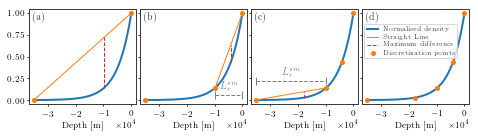

In [43]:
heights = np.linspace(bottom, top, 101)
fig, axes = plt.subplots(1, len(subsets),
                         figsize=(6.66, 2),
                         sharey=True)
labels = ["(a)", "(b)", "(c)", "(d)"]
divisions = np.array([top, bottom])

for i in range(len(subsets) - 1):
    ax = axes[i]
    subset = subsets[i]
    
    tops = [tess[-2] for tess in subset]
    bottoms = [tess[-1] for tess in subset]
    divisions = np.unique(np.array(tops + bottoms))
    
    tops = [tess[-2] for tess in subsets[i + 1]]
    bottoms = [tess[-1] for tess in subsets[i + 1]]
    new_divisions = np.unique(np.array(tops + bottoms))
    
    line1 = ax.plot(heights, normalized_density(heights),
                    linewidth=2)
    dots = ax.plot(divisions, normalized_density(divisions), 'o')
    for j in range(1, len(new_divisions) - 1):
        bottom_j = new_divisions[j - 1]
        top_j = new_divisions[j + 1]
        div = new_divisions[j]
        if div not in divisions:
            line2 = ax.plot([div]*2,
                            [normalized_density(div),
                             line(div, top_j, bottom_j)],
                            '--', color="C3")
            line3 = ax.plot([bottom_j, top_j],
                            [normalized_density(bottom_j),
                             normalized_density(top_j)],
                            '-', color="C1")
            if i == 1:
                ax.plot([bottom_j, top_j],
                        [normalized_density(bottom_j) - 0.08]*2, "|--",
                        color="C7", markersize=8)
                ax.text(0.5*(bottom_j + top_j),
                        normalized_density(bottom_j) - 0.03,
                        '$L_r^{sm}$',
                        fontdict={'color': "C7"},
                        horizontalalignment='center')
            elif i == 2:
                ax.plot([bottom_j, top_j],
                        [normalized_density(top_j) + 0.08]*2, "|--",
                        color="C7", markersize=8)
                ax.text(0.5*(bottom_j + top_j),
                        normalized_density(top_j) + 0.13,
                        '$L_r^{sm}$',
                        fontdict={'color': "C7"},
                        horizontalalignment='center')

ax = axes[-1]
tops = [tess[-2] for tess in subsets[-1]]
bottoms = [tess[-1] for tess in subsets[-1]]
divisions = np.unique(np.array(tops + bottoms))
ax.plot(heights, normalized_density(heights),
        linewidth=2)
ax.plot(divisions, normalized_density(divisions), 'o')

for ax, label in zip(axes, labels):
    ax.text(0.03, 0.91, label,
            fontdict={'weight': 'bold'},
            verticalalignment="center",
            transform=ax.transAxes)
    ax.set_xlabel("Depth [m]")
    ax.set_xticks([-3e4, -2e4, -1e4, 0])
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

axes[-1].legend((line1[0], line3[0], line2[0], dots[0]),
                ("Normalised density",
                 "Straight Line",
                 "Maximum difference",
                 "Discretization points"),
                fontsize="xx-small",
                loc=(0.02, 0.48))

plt.tight_layout(pad=1, h_pad=0, w_pad=0)
plt.savefig("../../manuscript/figures/" +
            "density-based-discretization-algorithm.pdf")
plt.show()

## Speed comparison

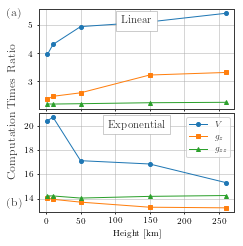

In [3]:
fields = 'potential gz gzz'.split()
labels = r'$V$ $g_z$ $g_{zz}$'.split()
markers = ["o", "s", "^"]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((3.33, 3.5))



with open('results/speed-comparison/times_homogeneous.pkl', 'r') as outfile:
    times_homogeneous = pickle.load(outfile)

with open('results/speed-comparison/times_linear.pkl', 'r') as outfile:
    times_variable = pickle.load(outfile)

for field, label, marker in zip(fields, labels, markers):
    heights = times_homogeneous['heights']
    ratio = times_variable[field]/times_homogeneous[field]
    ax1.plot(heights/1000, ratio, '-', marker=marker, label=label)
    ax1.grid(True, linewidth=0.5, color='#aeaeae')

ax1.text(-0.16, 0.93, "(a)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax1.transAxes)
ax1.text(0.5, 0.88, "Linear", fontsize=11,
         horizontalalignment='center',
         verticalalignment='center',
         bbox={'facecolor': 'w',
               'edgecolor': '#9b9b9b',
               'linewidth': 0.5, 'pad': 5},
               transform=ax1.transAxes)


with open('results/speed-comparison/times_homogeneous.pkl', 'r') as outfile:
    times_homogeneous = pickle.load(outfile)

with open('results/speed-comparison/times_exponential.pkl', 'r') as outfile:
    times_variable = pickle.load(outfile)

for field, label, marker in zip(fields, labels, markers):
    heights = times_homogeneous['heights']
    ratio = times_variable[field]/times_homogeneous[field]
    ax2.plot(heights/1000, ratio, '-', marker=marker, label=label)
    ax2.grid(True, linewidth=0.5, color='#aeaeae')


ax2.text(-0.16, 0.07, "(b)", fontsize=12,
         fontdict={'weight': 'bold'},
         transform=ax2.transAxes)
ax2.text(0.5, 0.88, "Exponential", fontsize=11,
         horizontalalignment='center',
         verticalalignment='center',
         bbox={'facecolor': 'w',
               'edgecolor': '#9b9b9b',
               'linewidth': 0.5, 'pad': 5},
               transform=ax2.transAxes)

ax2.text(-0.16, 1.6, "Computation Times Ratio",
         fontsize=12, rotation="vertical",
         fontdict={'weight': 'bold'},
         transform=ax2.transAxes)


ax2.set_xlabel('Height [km]')
plt.legend()

plt.tight_layout(pad=1, h_pad=0, w_pad=0)
plt.savefig('../manuscript/figures/speed-comparison.pdf')
plt.show()

## Tesseroid vs Spherical Shell with Linear Density

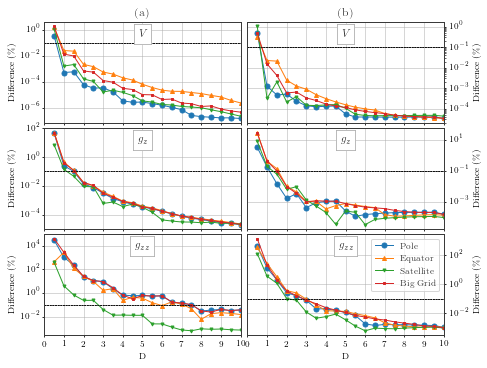

In [27]:
# Figure setup
fig, all_axes = plt.subplots(nrows=3, ncols=2,
                             sharex=True)
fig.set_size_inches((6.66, 5))
fig.subplots_adjust(hspace=0)

# Thin Shell
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['C' + str(i) for i in range(4)]
labels = [r'Pole', r'Equator', r'Satellite', r'Big Grid']
titles = '$V$ $g_z$ $g_{zz}$'.split()

axes = [ax[0] for ax in all_axes]
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/linear-D/' + field + '-' + grid + '-thin-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([0, 10], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
axes[0].set_title('(a)')


# Thick Shell
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['C' + str(i) for i in range(4)]
labels = [r'Pole', r'Equator', r'Satellite', r'Big Grid']
titles = '$V$ $g_z$ $g_{zz}$'.split()

axes = [ax[1] for ax in all_axes]
for ax, field, title in zip(axes, fields, titles):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/linear-D/' + field + '-' + grid + '-thick-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([0, 10], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position('right')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)

ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
axes[0].set_title('(b)')

plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.savefig('../../manuscript/figures/linear-D.pdf')
plt.show()

## Tesseroid vs Spherical Shell: Grid Search with Exp density

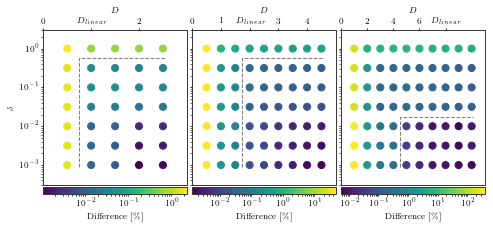

In [102]:
top, bottom = 0, -35000
fields = 'potential gz gzz'.split()
Ds_linear = [1, 2, 8]

fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches((6.66, 3))

for field, ax, D_linear in zip(fields, axes, Ds_linear):
    data = np.load('results/grid-search/' +
                   field + '-thick-differences.npz')
    D_grid, delta_grid = data['D_grid'], data['delta_grid']
    errors = data['errors']
    
    # Plot bigger points if error <= 0.1
    plot_sizes = False
    size = 50
    if plot_sizes:
        sizes = size*np.ones_like(errors)
        sizes[errors<=0.1] = 3*size
    else:
        sizes = size
    cm = ax.scatter(D_grid.ravel(), delta_grid.ravel(),
                    s=sizes, c=errors.ravel(),
                    norm=matplotlib.colors.LogNorm())
    
    # Bellow error points contour
    D_step = abs((D_grid.max() - D_grid.min())/(D_grid.shape[1] - 1))
    delta_factor = abs(delta_grid.max()/delta_grid.min())**(1/(delta_grid.shape[0] - 1))
    min_D = np.min(D_grid[errors <= 0.1]) - D_step/2
    max_D = D_grid.max() + D_step/8
    min_delta = delta_grid.min()*(delta_factor**(-0.125))
    max_delta = np.max(delta_grid[errors <= 0.1])*(delta_factor**0.5)
    ax.plot([min_D, min_D, max_D],
              [min_delta, max_delta, max_delta],
              '--', color='C7')
    
    plt.colorbar(cm, label='Difference [\%]',
                 ax=ax,
                 orientation="horizontal",
                 pad=0.01)
    
    
    if field == "potential":
        ax.set_xticks(np.arange(0, 3, 1))
    elif field == "gz":
        ax.set_xticks(np.arange(0, 5, 1))
    elif field == "gzz":
        ax.set_xticks(np.arange(0, 10, 2))
    
    ax.set_xlabel("$D$")
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    ax.set_xlim(D_grid.min() - D_step,
                D_grid.max() + D_step)
    ax.set_ylim(3e-4, 3e0)
    ax.set_yscale('log')
    
    
    plt.draw()
    
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(len(labels)):
        label = labels[i]
        label = label.replace("$", "")
        try:
            if float(label) == D_linear:
                labels[i] = "$D_{linear}$"
        except:
            continue
    ax.set_xticklabels(labels)
    
axes[0].set_ylabel("$\delta$")
plt.tight_layout(pad=0, h_pad=0)
plt.savefig("../../manuscript/figures/grid-search.pdf")
plt.show()

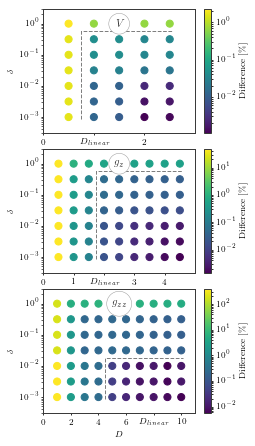

In [149]:
top, bottom = 0, -35000
fields = 'potential gz gzz'.split()
Ds_linear = [1, 2, 8]
titles = "$V$ $g_z$ $g_{zz}$".split()

fig, axes = plt.subplots(3, 1)
fig.set_size_inches((3.33, 6))

for field, title, ax, D_linear in zip(fields, titles, axes, Ds_linear):
    data = np.load('results/grid-search/' +
                   field + '-thick-differences.npz')
    D_grid, delta_grid = data['D_grid'], data['delta_grid']
    errors = data['errors']
    
    # Plot bigger points if error <= 0.1
    plot_sizes = False
    size = 50
    if plot_sizes:
        sizes = size*np.ones_like(errors)
        sizes[errors<=0.1] = 3*size
    else:
        sizes = size
    cm = ax.scatter(D_grid.ravel(), delta_grid.ravel(),
                    s=sizes, c=errors.ravel(),
                    norm=matplotlib.colors.LogNorm())
    
    # Bellow error points contour
    D_step = abs((D_grid.max() - D_grid.min())/(D_grid.shape[1] - 1))
    delta_factor = abs(delta_grid.max()/delta_grid.min())**(1/(delta_grid.shape[0] - 1))
    min_D = np.min(D_grid[errors <= 0.1]) - D_step/2
    max_D = D_grid.max() + D_step/8
    min_delta = delta_grid.min()*(delta_factor**(-0.125))
    max_delta = np.max(delta_grid[errors <= 0.1])*(delta_factor**0.5)
    ax.plot([min_D, min_D, max_D],
              [min_delta, max_delta, max_delta],
              '--', color='C7')
    
    # Colorbar
    plt.colorbar(cm, label='Difference [\%]',
                 ax=ax, pad=0.05)
    
    # Plot config
    if field == "potential":
        ax.set_xticks(np.arange(0, 3, 1))
    elif field == "gz":
        ax.set_xticks(np.arange(0, 5, 1))
    elif field == "gzz":
        ax.set_xticks(np.arange(0, 11, 2))
    
    ax.set_xlim(D_grid.min() - D_step,
                D_grid.max() + D_step)
    
    ax.text(0.5, 0.88, title, fontsize=11,
            horizontalalignment='center',
            verticalalignment='center',
            bbox={'facecolor': 'w',
                  'edgecolor': '#9b9b9b',
                  'linewidth': 0.5, 'pad': 5,
                  'boxstyle': 'circle, pad=0.5'},
            transform=ax.transAxes)

    ax.set_ylim(3e-4, 3e0)
    ax.set_yscale('log')
    ax.set_ylabel("$\delta$")
    
    # Insert D_linear label in axis ticks
    plt.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    for i in range(len(labels)):
        label = labels[i]
        label = label.replace("$", "")
        try:
            if float(label) == D_linear:
                labels[i] = "$D_{linear}$"
        except:
            continue
    ax.set_xticklabels(labels)

axes[-1].set_xlabel("$D$")
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.savefig("../../manuscript/figures/grid-search.pdf")
plt.show()

## Tesseroid vs Spherical Shell with Exponential Density

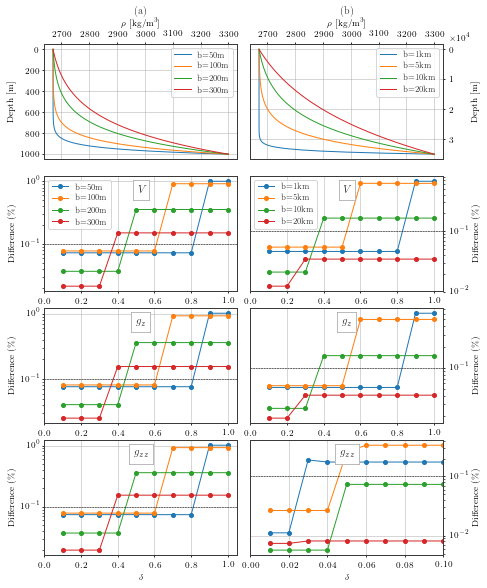

In [200]:
# Figure Setup
fig, all_axes = plt.subplots(nrows=4, ncols=2)
fig.set_size_inches((6.66, 8))
# fig.subplots_adjust(hspace=0.2, wspace=0.04)
# fig.tight_layout(pad=3.5, h_pad=0, w_pad=0)
# fig.tight_layout(rect=[0.02, 0.005, 0.95, 0.97])
# fig.tight_layout(pad=3.4, h_pad=0, w_pad=-1)
fig.tight_layout(rect=[0.025, 0.001, 0.95, 0.955],
                 h_pad=0, w_pad=-1)


# Thin Shell
# ----------
top, bottom = 0, -1000
fields = 'potential gz gzz'.split()
titles = '$V$ $g_z$ $g_{zz}$'.split()
b_values = [50, 100, 200, 300]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
labels = ["b=" + str(b) + "m" for b in b_values]
heights = np.linspace(bottom, top, 101)

axes = [ax[0] for ax in all_axes]
ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, title, ax in zip(fields, titles, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thin-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
axes[1].legend(fontsize='small')

ax1.legend(fontsize='small')
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]")
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.text(0.5, 1.28, '(a)',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes)

for ax in axes[1:]:
    ax.plot([0, 1.2], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(0, 1.05)
    ax.set_yscale('log')
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)

axes[-1].set_xlabel(r"$\delta$")


# Thick Shell
# -----------
top, bottom = 0, -35000
fields = 'potential gz gzz'.split()
b_values = [1e3, 5e3, 1e4, 2e4]
deltah = MEAN_EARTH_RADIUS
rho0, rho1 = 2670, 3300
labels = ["b=" + str(int(b*1e-3)) + "km" for b in b_values]
heights = np.linspace(bottom, top, 101)

axes = [ax[1] for ax in all_axes]
ax1 = axes[0]

for b, label in zip(b_values, labels):    
    
    # Define constant a in order to normalize the density function
    a = (rho1 - rho0)/(np.exp((abs(top - bottom))/b) - 1)
    c = rho0 - a
    
    # Define new functions for each b
    def density_exponential(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp(-(r - deltah)/b) + c

    ax1.plot(density_exponential(heights), -heights,
             '-', label=label)

for field, title, ax in zip(fields, titles, axes[1:]):
    for b, label in zip(b_values, labels):  
        diffs = np.load('results/exponential-delta/' + field + '-' +
                        '{:.1e}'.format(b) + '-thick-differences.npz')
        deltas, diff = diffs['deltas'], diffs['diffs']
        ax.plot(deltas, diff, 'o-',
                markersize=4, label=label)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
axes[1].legend(fontsize='small')

ax1.legend(fontsize='small')
ax1.grid(True, linewidth=0.5, color='#aeaeae')
ax1.set_xlabel(r"$\rho$ [kg/m$^3$]")
ax1.set_ylabel("Depth [m]", labelpad=18)
ax1.invert_yaxis()
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax1.get_yaxis().get_offset_text().set_x(1.14)
ax1.text(0.5, 1.28, '(b)',
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax1.transAxes)

for ax in axes[1:3]:
    ax.plot([0, 1.2], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
    ax.set_xlim(0, 1.05)
    ax.set_yscale('log')
    ax.set_ylabel('Difference (\%)')
    ax.grid(True, linewidth=0.5, color='#aeaeae')
    ax.set_axisbelow(True)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

ax = axes[3]
ax.plot([0, 1.2], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
ax.set_xlim(0, 0.1)
ax.set_yscale('log')
ax.set_ylabel('Difference (\%)')
ax.grid(True, linewidth=0.5, color='#aeaeae')
ax.set_axisbelow(True)
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax.set_xlabel(r"$\delta$")

plt.savefig('../../manuscript/figures/exponential-delta.pdf')
plt.show()

## Nequen Basin

### Load Data: Topography and Sediment Thickness

In [3]:
data = np.load("../data/topography.npy")
lat, lon, topo = data[:, 0], data[:, 1], data[:, 2]
shape = (571, 457)
area = (lat.min(), lat.max(), lon.min(), lon.max())

topography = {'lon': lon, 'lat': lat, 'topo': topo,
              'shape': shape, 'area': area}

lat, lon, thickness = np.loadtxt('../data/sediment_thickness.dat',
                                 unpack=True)
shape = (117, 91)
area = (lat.min(), lat.max(), lon.min(), lon.max())
sediments = {'lon': lon, 'lat':lat, 'thickness': thickness,
             'shape': shape, 'area': area}

### Load Data: Computed Fields

In [4]:
fields = 'potential gx gy gz gxy gzz'.split()
shape = (79, 81)
area = (-40.8, -33., 287, 295.)
lat, lon, height = gridder.regular(area, shape, z=260e3)

variable, homogeneous = [], []
for field in fields:
    filename = "results/neuquen-basin/homogeneous/" + field + ".npy"
    homogeneous.append(np.load(filename))
    filename = "results/neuquen-basin/variable/" + field + ".npy"
    variable.append(np.load(filename))

results = {'lat': lat, 'lon': lon, 'height': height,
           'shape': shape, 'area': area,
           'variable': variable, 'homogeneous': homogeneous}

### Create Basemap and configuration of draws

In [5]:
area = topography['area']

bm = Basemap(projection='merc',
             llcrnrlon=area[2],
             llcrnrlat=area[0],
             urcrnrlon=area[3],
             urcrnrlat=area[1],
             resolution='i')

config = {'countries': dict(linewidth=0.5, color='k'),
          'states': dict(linewidth=0.4, linestyle='--', color='k'),
          'coastlines': dict(linewidth=0.5, color='k'),
          'meridians': dict(meridians=np.arange(-80, -50, 2),
                            linewidth=0.5,
                            labels=[False, False, True, False],
                            labelstyle='+/-'),
          'parallels': dict(circles=np.arange(-50, -30, 2),
                            linewidth=0.5,
                            labels=[True, False, False, False],
                            labelstyle='+/-')}

config['parallels-quiet'] = config['parallels'].copy()
config['parallels-quiet']['labels'] = [False, False, False, False]

config['meridians-quiet'] = config['meridians'].copy()
config['meridians-quiet']['labels'] = [False, False, False, False]

config['parallels-right'] = config['parallels'].copy()
config['parallels-right']['labels'] = [False, True, False, False]

### Plot

/home/santi/.anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/santi/.anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was depre

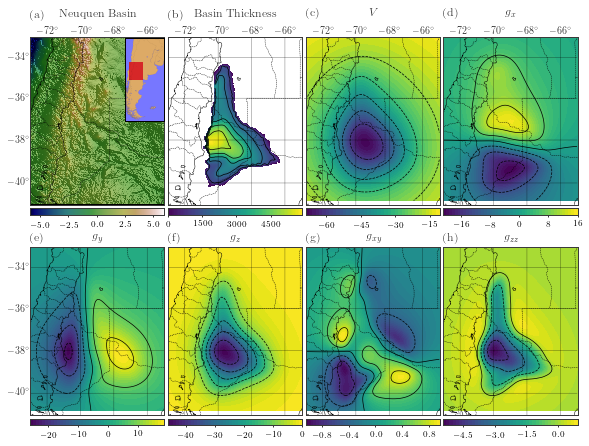

In [6]:
fig = plt.figure(figsize=(8, 6.08))

grid = AxesGrid(fig, [0.04, 0, 0.95, 0.97],
                nrows_ncols=(2, 4), axes_pad=(0.05, 0.45),
                cbar_location="bottom", cbar_mode="each",
                cbar_size="4%", cbar_pad=0.05)

# --------------
# Topography Map
# --------------
ax, bm.ax, cbax = grid[0], grid[0], grid.cbar_axes[0]
ax.set_title("Neuquen Basin", y=1.08, loc="center")
ax.set_title("(a)", y=1.08, loc="left")
x, y = bm(topography['lon'], topography['lat'])
shape = topography['shape']
vmax = np.abs([np.nanmin(topography['topo']),
               np.nanmax(topography['topo'])]).max()
vmin = -vmax
cmap = plt.cm.gist_earth

# Hillshaded topography
ls = LightSource(azdeg=120)
rgb = ls.shade(topography['topo'].reshape(shape),
               cmap, blend_mode='soft', vert_exag=1000,
               vmin=vmin, vmax=vmax)
bm.imshow(rgb)

# Proxy image for colorbar
im = bm.imshow(1e-3*topography['topo'].reshape(shape), cmap=cmap)
im.remove()
cbar = cbax.colorbar(im)

# Basemap configuration
bm.drawcountries(**config['countries'])
bm.drawstates(**config['states'])
bm.drawcoastlines(**config['coastlines'])
l = bm.drawmeridians(**config['meridians'])
for element in l.keys():
    lines, texts = l[element]
    for line in lines:
        line.remove() # remove meridians lines
l = bm.drawparallels(**config['parallels'])
for element in l.keys():
    lines, texts = l[element]
    for line in lines:
        line.remove() # remove parallels lines

# Location map
height, width = "50%", "29.375%"
axins = inset_axes(ax,
                   width=width,
                   height=height,
                   loc=1,
                   borderpad=0)
bm2 = Basemap(projection='merc',
               llcrnrlon=360 - 75, llcrnrlat=-56,
               urcrnrlon=360 - 53, urcrnrlat=-21,
               resolution='i', ax=axins)
bm2.drawmapboundary(fill_color='#7777ff')
bm2.fillcontinents(color='#ddaa66', lake_color='#7777ff')
bm2.drawcountries(linewidth=0.02)
bm2.drawcoastlines(linewidth=0.02)
x1, y1 = bm2(area[2], area[0])
x2, y2 = bm2(area[3], area[1])
rectangle = Rectangle((x1, y1),
                      abs(x2 - x1),
                      abs(y2 - y1),
                      facecolor='C3')
axins.add_patch(rectangle)


# ---------------
# Basin thickness
# ---------------
ax, bm.ax, cbax = grid[1], grid[1], grid.cbar_axes[1]
ax.set_title("Basin Thickness", y=1.08, loc="center")
ax.set_title("(b)", y=1.08, loc="left")
x, y = bm(sediments['lon'], sediments['lat'])
im = bm.contourf(x.reshape(sediments['shape']),
                 y.reshape(sediments['shape']),
                 sediments['thickness'].reshape(sediments['shape']),
                 100)
bm.contour(x.reshape(sediments['shape']),
           y.reshape(sediments['shape']),
           sediments['thickness'].reshape(sediments['shape']),
           5, colors='k', linewidths=0.7)
bm.drawcountries(**config['countries'])
bm.drawstates(**config['states'])
bm.drawcoastlines(**config['coastlines'])
bm.drawparallels(**config['parallels-right'])
bm.drawmeridians(**config['meridians'])
cbax.colorbar(im)


# ---------------
# Computed Fields
# ---------------
titles = ["$V$", "$g_x$", "$g_y$",
          "$g_z$", "$g_{xy}$", "$g_{zz}$"]
subfigures = "(c) (d) (e) (f) (g) (h)".split()

lon, lat = results['lon'], results['lat']
shape = results['shape']

for i in range(len(titles)):
    ax, bm.ax, cbax = grid[i+2], grid[i+2], grid.cbar_axes[i+2]
    x, y = bm(lon, lat)
    result = results['variable'][i]
    im = bm.contourf(x.reshape(shape), y.reshape(shape),
                     result.reshape(shape), 50)
    bm.contour(x.reshape(shape), y.reshape(shape),
               result.reshape(shape),
               5, colors='k', linewidths=0.7)
    bm.drawcountries(**config['countries'])
    bm.drawstates(**config['states'])
    bm.drawcoastlines(**config['coastlines'])
    if i == 2:
        bm.drawparallels(**config['parallels'])
    else:
        bm.drawparallels(**config['parallels-quiet'])
    if i > 1:
        bm.drawmeridians(**config['meridians-quiet'])
        ax.set_title(titles[i], loc="center")
        ax.set_title(subfigures[i], loc="left")
    else:
        bm.drawmeridians(**config['meridians'])
        ax.set_title(titles[i], y=1.09, loc="center")
        ax.set_title(subfigures[i], y=1.09, loc="left")
    cbar = cbax.colorbar(im)

plt.savefig('../manuscript/figures/neuquen-basin.pdf', dpi=300)
plt.show()